In [85]:
import pandas as pd

data = pd.read_csv("./clean_weather.csv", index_col=0)
data = data.ffill()

data

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0
...,...,...,...,...
2022-11-22,62.0,35.0,0.0,67.0
2022-11-23,67.0,38.0,0.0,66.0
2022-11-24,66.0,41.0,0.0,70.0
2022-11-25,70.0,39.0,0.0,62.0


<AxesSubplot:xlabel='tmax', ylabel='tmax_tomorrow'>

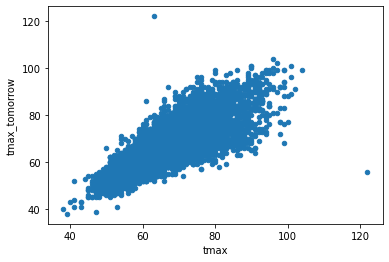

In [86]:
data.plot.scatter("tmax", "tmax_tomorrow")

In [87]:
data.corr()
# Mejor correlación entre más cercano a 1 o -1

,tmax,tmin,rain,tmax_tomorrow
tmax,1.000000,0.615604,-0.219941,0.818561
tmin,0.615604,1.000000,-0.019546,0.585572
rain,-0.219941,-0.019546,1.000000,-0.211799
tmax_tomorrow,0.818561,0.585572,-0.211799,1.000000


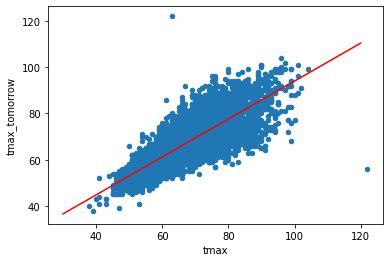

In [88]:
import matplotlib.pyplot as plt

data.plot.scatter("tmax", "tmax_tomorrow")

# Función de predicción muy buena o ideal sobre el clima
prediction = lambda x, w1=0.82, b=11.99: x * w1 + b

plt.plot([30, 120], [prediction(30), prediction(120)], "red")

In [89]:
import numpy as np


def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)


print(mse(data["tmax_tomorrow"], prediction(data["tmax"])))
print(mse(data["tmax_tomorrow"], prediction(data["tmax"], 0.82, 13)))

22.897335324598394
24.11828543933663


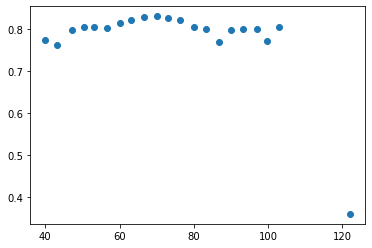

In [90]:
tmax_bins = pd.cut(data["tmax"], 25)

ratios = (data["tmax_tomorrow"] - 11.99) / data["tmax"]
binned_ratio = ratios.groupby(tmax_bins).mean()

binned_tmax = data["tmax"].groupby(tmax_bins).mean()

# Relación que no es constante, muy variable podría llegar a ser
plt.scatter(binned_tmax, binned_ratio)

Esta relación no es posible plantearla con un modelo lineal, ya que puede darse momentos donde la temperatura de mañana se parezca a la de hoy pero no es una situación que suceda siempre

Lineal sería $y = x \times w + b$, pero para una no linear se manejan otros casos que serían las funciones de activación.

Por ejemplo:
+ Con ReLu: $y = ReLu(x \times w + b)$, aquí los valores debajo de cero se convierten en cero, mientras que los valores por encima se mantienen.

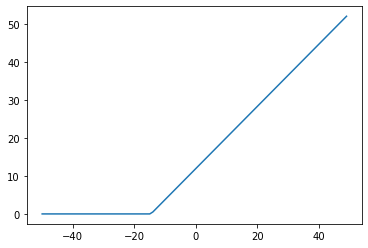

In [91]:
temps = np.arange(-50, 50)

plt.plot(temps, np.maximum(0, prediction(temps)))

## Múltiples capas

Para evitar truncar tan fuerte algunos datos que podrían tener mayor impacto, se manejan más capas con el fin de mejorar el modelo

Ejemplo:
$y = w_{2} \times ReLu(w_{1} \times x + b_{1}) + b_{2}$
La capa 1 es la del ReLu, la segunda es multiplicar ese resultado de la primera capa por el peso de la segunda sumado su respectivo sesgo

(0.0, 40.0)

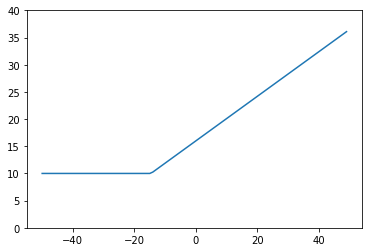

In [92]:
temps = np.arange(-50, 50)

layer1 = np.maximum(0, prediction(temps))
layer2 = prediction(layer1, 0.5, 10)

plt.plot(temps, layer2)

plt.ylim((0, 40))

A pesar de la mejora, sigue siendo algo muy estricto con solo 2 capas con un único nodo. Por ello, se requiere de añadir más unidades o nodos ocultos en las capas

## Múltiples unidades ocultas

Con mayor número de unidades ocultas, se puede hacer que el modelo sea máx complejo y sea no linear

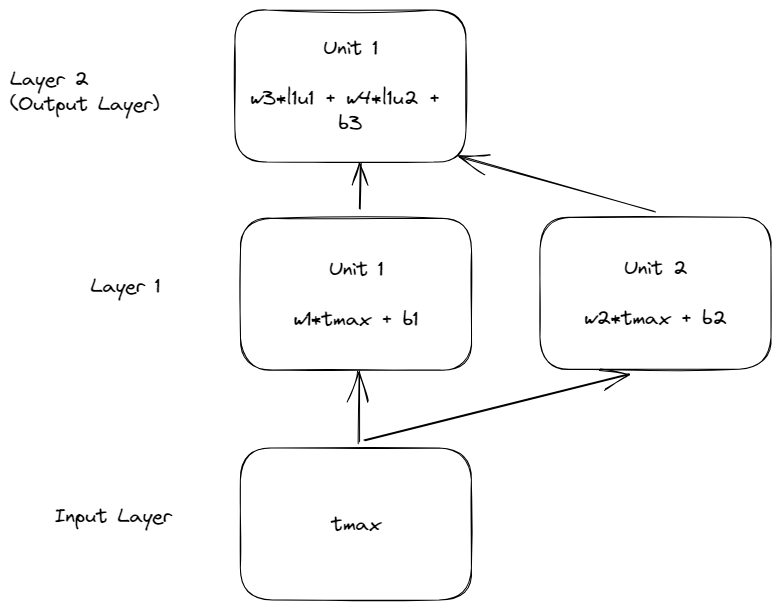

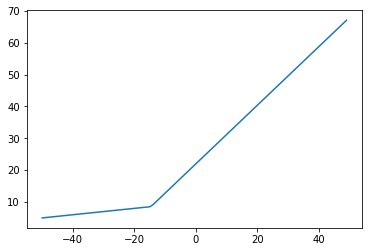

In [93]:
layer1_1 = np.maximum(0, prediction(temps))

layer1_2 = np.maximum(0, prediction(temps, 0.1, 10))

plt.plot(temps, layer1_1 + layer1_2)

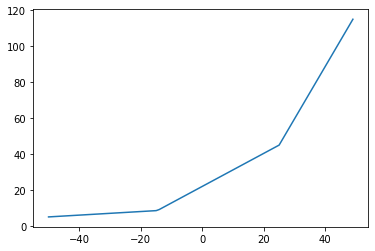

In [94]:
layer1_3 = np.maximum(0, prediction(temps, 2, -50))

plt.plot(temps, layer1_1 + layer1_2 + layer1_3)

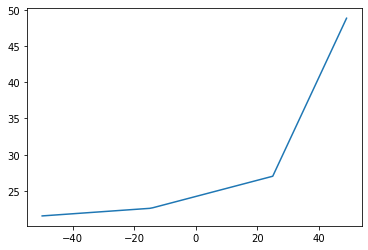

In [95]:
layer2 = layer1_1 * 0.1 + layer1_2 * 0.3 + layer1_3 * 0.4 + 20

plt.plot(temps, layer2)

Una forma rápida de saber el resultado de una capa es con ayuda de la mutiplicación matricial. Manejando una matriz de inputs, una con los pesos y otra con los sesgos. Así, hacemos $inputs \times pesos + sesgo$

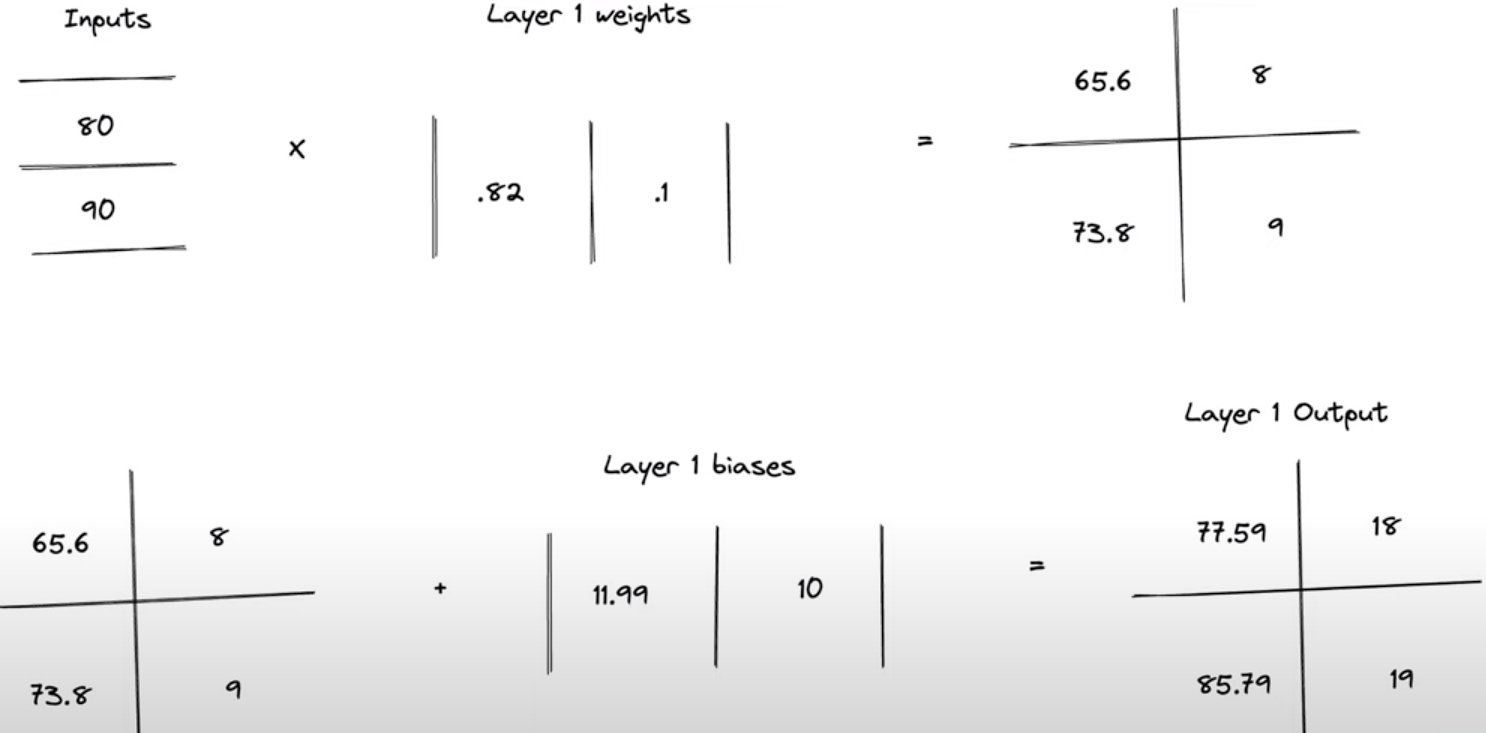

Ahora, vamos a aplicar esto

In [96]:
input_vals = np.array([[80], [90], [100], [-20], [-10]])

l1_weights = np.array([[0.82, 0.1]])

l1_bias = np.array([[11.99, 10]])

l1_output = input_vals @ l1_weights + l1_bias

In [97]:
l1_activation = np.maximum(l1_output, 0)

In [98]:
l1_activation

array([[77.59, 18.  ],
       [85.79, 19.  ],
       [93.99, 20.  ],
       [ 0.  ,  8.  ],
       [ 3.79,  9.  ]])

Con esto, la ecuación de antes se vería como $Layer_1 = ReLu(X \times W_1 + B_1)$. De forma similar se podría hacer con la capa 2

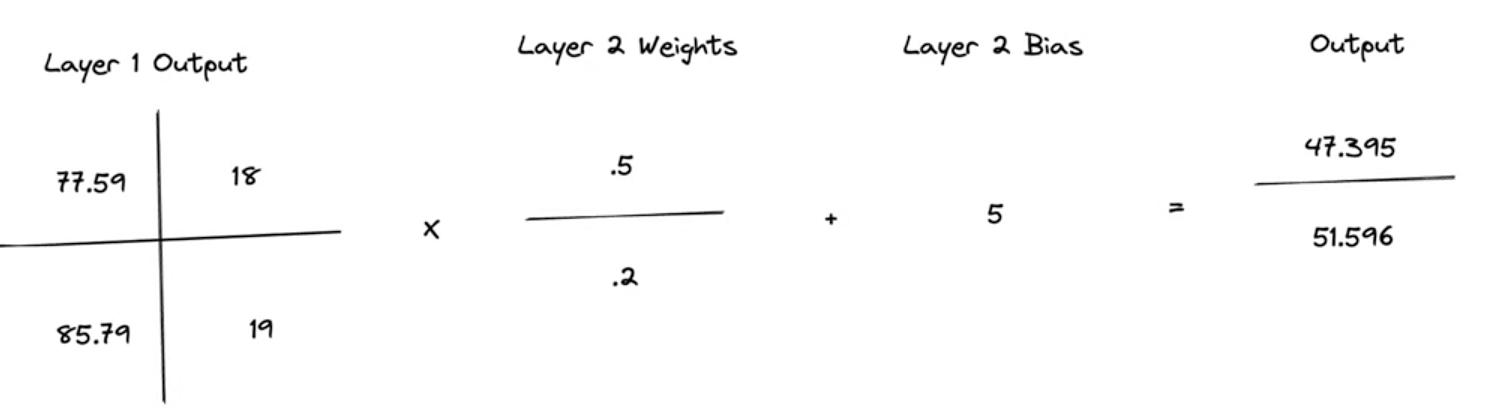

In [99]:
l2_weights = np.array([[0.5], [0.2]])

l2_bias = np.array([[5]])

l2_output = l1_activation @ l2_weights + l2_bias
l2_output

array([[47.395],
       [51.695],
       [55.995],
       [ 6.6  ],
       [ 8.695]])

In [100]:
# Entra descenso gradiente

tmax = np.array([[80], [90], [100], [-20], [-10]])
tmax_tomorrow = np.array([[83], [89], [95], [-22], [-9]])

In [101]:
def mse2(actual, predicted):
    return (actual - predicted) ** 2

In [102]:
mse2(tmax_tomorrow, l2_output)

array([[1267.716025],
       [1391.663025],
       [1521.390025],
       [ 817.96    ],
       [ 313.113025]])

In [103]:
# Cuánto toca corregir la función de pérdida
def mse_grad(actual, predicted):
    return predicted - actual

In [104]:
mse_grad(tmax_tomorrow, l2_output)

array([[-35.605],
       [-37.305],
       [-39.005],
       [ 28.6  ],
       [ 17.695]])

## Ya pasamos por el paso hacía adelante, ahora toca hacía atrás. (forward pass ==> backward pass)

Ya que sabemos cuánto toca cambiar los pesos, vamos a aplicarlo en el modelo para que se corrija y mejore su respuesta por sí solo.

**Propagación hacía adelante con operaciones a invertir**

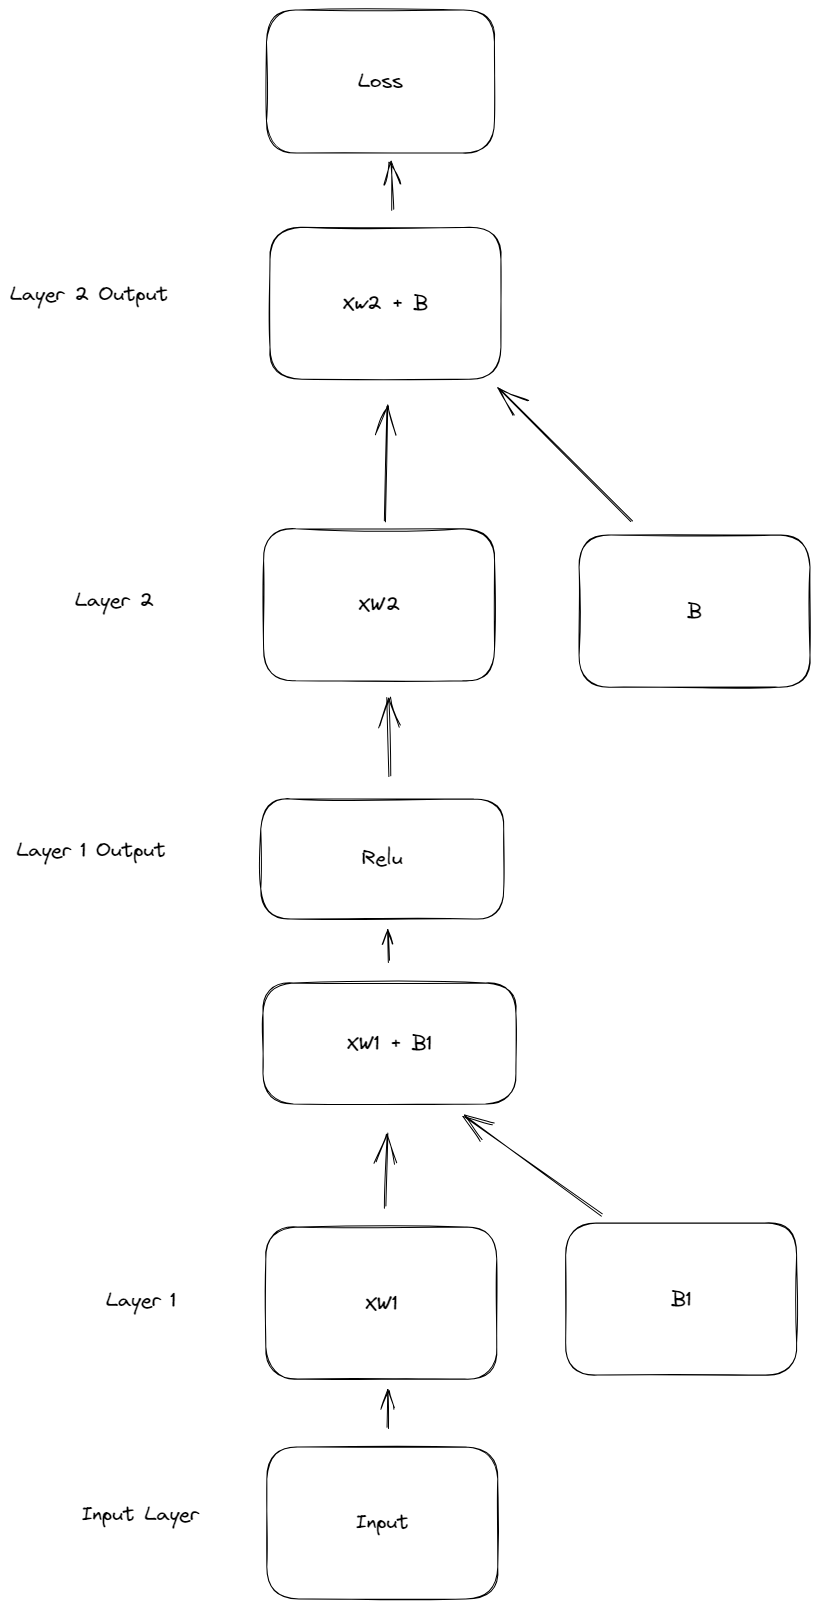

**Así será como se invierte o se propaga hacía atrás**

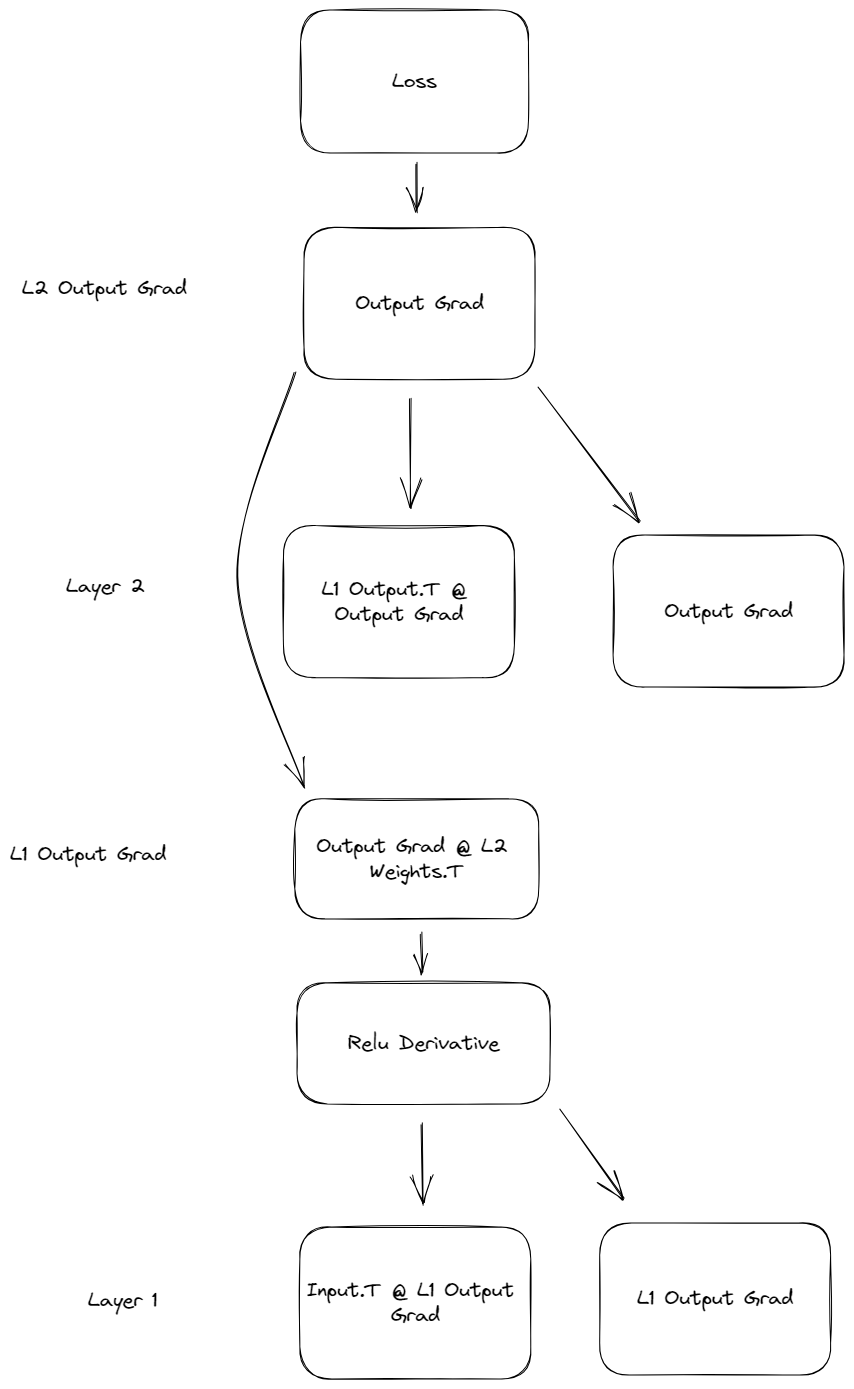

In [105]:
output_gradient = mse_grad(tmax_tomorrow, l2_output)

#### Gradientes de la capa 2

In [106]:
l2_w_gradient = l1_activation.T @ output_gradient
l2_w_gradient

array([[-9562.0038],
       [-1741.73  ]])

Lo que se hará para este cambio, es aplicar la propagación hacía atrás. Partiendo de la capa final hacía la anterior. En este caso, hacía la capa 2 que se vería como $\frac{\partial L}{\partial W_2}$. Esto sería:

$$\frac{\partial L}{\partial W_2} = \partial L \frac{\partial (X W_2)}{\partial W_2}$$

In [107]:
from sympy import diff, symbols

# Esto es la derivada parcial de XW2 respecto a W2

x, w = symbols("X, W")
sympy_output = x * w
diff(sympy_output, w)

X

Luego,

$$\frac{\partial L}{\partial W_2} = \partial L X$$

Esta regla de la cadena se aplica para encontrar el nuevo valor de cada parámetro. Es decir, aplica al peso y sesgo de cada capa

In [108]:
l2_b_gradient = np.mean(output_gradient, axis=0)
l2_b_gradient

array([-13.124])

In [109]:
# Pesos originales de la capa 2
l2_weights

array([[0.5],
       [0.2]])

In [110]:
lr = 1e-5  # Tasa de aprendizaje en 1^-5

# Actualizar sesgo y peso
l2_bias = l2_bias - l2_b_gradient * lr
l2_weights = l2_weights - l2_w_gradient * lr

l2_weights

array([[0.59562004],
       [0.2174173 ]])

In [111]:
l2_bias

array([[5.00013124]])

#### Gradientes de la capa 1

In [112]:
l1_activation_gradient = output_gradient @ l2_weights.T
l1_activation_gradient

array([[-21.20705145,  -7.74114297],
       [-22.21960552,  -8.11075238],
       [-23.23215958,  -8.48036179],
       [ 17.03473309,   6.21813478],
       [ 10.53949657,   3.84719912]])

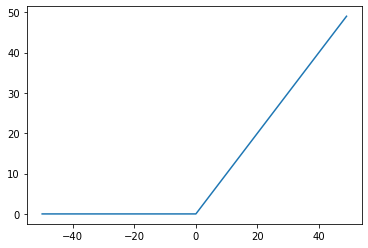

In [113]:
plt.plot(temps, np.maximum(0, temps))

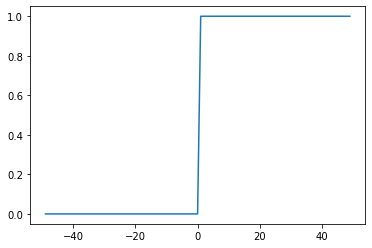

In [114]:
activation = np.maximum(0, temps)

plt.plot(temps[1:], activation[1:] - np.roll(activation, 1)[1:])

In [115]:
l1_output_gradient = l1_activation_gradient * np.heaviside(l1_output, 0)
# Lo que aporta, se mantiene. Lo que no, se vuelve cero al no tener peso en los valores posteriores
l1_output_gradient

array([[-21.20705145,  -7.74114297],
       [-22.21960552,  -8.11075238],
       [-23.23215958,  -8.48036179],
       [  0.        ,   6.21813478],
       [ 10.53949657,   3.84719912]])

In [116]:
l1_w_gradient = input_vals.T @ l1_output_gradient
l1_b_gradient = np.mean(l1_output_gradient, axis=0)

# Actualizamos los pesos y sesgo de la capa 1
l1_weights -= l1_w_gradient * lr
l1_bias -= l1_b_gradient * lr

In [117]:
l1_weights

array([[0.8812494, 0.1236013]])

In [118]:
l1_bias

array([[11.99011224, 10.00002853]])

### Algoritmo de entrenamiento de la red

1. Propagación hacia adelante y obtener los resultados
2. Computar el gradiente respecto a las salidas de la red (Función `mse_grad`)
3. Por cada capa:
   - Computar el gradiente respecto a la salida previa a la no linearidad (Si la capa es no linear)
   - Computar el gradiente respecto a los pesos
   - Computar el gradiente respecto a los sesgos
   - Computar el gradiente respecto a las entradas de la capa
4. Actualizar los parámetros de la red con descenso gradiente

En este caso, se contemplan las tandas de datos con las que se entrena la red (Batch size). A menor tanda, más rápido corre pero puede descender lento al dar tantas chances a actualizar los parámetros. Pero, si es muy grande la tanda, tardará mucho en correr y también tendrá un considerable o alto consumo de recursos. **Los extremos son malos**

In [119]:
import numpy as np
from sklearn.preprocessing import StandardScaler

PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data so relu works better
# All temperature values in the original dataset are over 0, so relu won't do much for several epochs
# Scaling will make some of the input data negative
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

split_data = np.split(data, [int(0.7 * len(data)), int(0.85 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [
    [d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data
]

### Implementación completa de la red

In [120]:
def init_layers(inputs):
    layers = []
    for i in range(1, len(inputs)):
        layers.append(
            [
                np.random.rand(inputs[i - 1], inputs[i]) / 5 - 0.1,
                np.ones((1, inputs[i])),
            ]
        )
    return layers


# This will initialize weights and biases for a 3-layer neural network with 10 units in the first layer, 10 in the second, and 1 in the final
# The first number (3) is our number of input features
layer_conf = [3, 10, 10, 1]

In [121]:
# Función para la propagación hacía adelante
def forward(batch, layers):
    hidden = [batch.copy()]
    for i in range(len(layers)):
        batch = np.matmul(batch, layers[i][0]) + layers[i][1]
        if i < len(layers) - 1:
            batch = np.maximum(batch, 0)
        # Store the forward pass hidden values for use in backprop
        hidden.append(batch.copy())
    return batch, hidden

In [122]:
def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)


def mse_grad(actual, predicted):
    return predicted - actual

In [123]:
def backward(layers, hidden, grad, lr):
    for i in range(len(layers) - 1, -1, -1):
        if i != len(layers) - 1:
            grad = np.multiply(grad, np.heaviside(hidden[i + 1], 0))

        w_grad = hidden[i].T @ grad
        b_grad = np.mean(grad, axis=0)

        layers[i][0] -= w_grad * lr
        layers[i][1] -= b_grad * lr

        grad = grad @ layers[i][0].T
    return layers

Ahora, ya teniendo las funciones del forward y backward propagation, las uniremos en un ciclo de entrenamiento

In [124]:
lr = 1e-6
epochs = 10
batch_size = 8

layers = init_layers(layer_conf)

for epoch in range(epochs):
    epoch_loss = 0

    for i in range(0, train_x.shape[0], batch_size):
        x_batch = train_x[i:(i + batch_size)]
        y_batch = train_y[i:(i + batch_size)]

        pred, hidden = forward(x_batch, layers)

        loss = mse_grad(y_batch, pred)
        epoch_loss += np.mean(loss ** 2)

        layers = backward(layers, hidden, loss, lr)

    valid_preds, _ = forward(valid_x, layers)

    print(f"Epoch {epoch} Train MSE: {epoch_loss / (train_x.shape[0] / batch_size)} Valid MSE: {np.mean(mse(valid_preds, valid_y))}")

Epoch 0 Train MSE: 3421.0950055907365 Valid MSE: 1963.4672880050045
Epoch 1 Train MSE: 428.84471389269277 Valid MSE: 29.786645752145933


Epoch 2 Train MSE: 24.575364704794378 Valid MSE: 21.894787517581054
Epoch 3 Train MSE: 22.754834430870773 Valid MSE: 20.98672136001076
Epoch 4 Train MSE: 22.258540985446807 Valid MSE: 20.788343168776258
Epoch 5 Train MSE: 22.131866711680697 Valid MSE: 20.75033793539586
Epoch 6 Train MSE: 22.09778937765986 Valid MSE: 20.745411576283487
Epoch 7 Train MSE: 22.087033105460296 Valid MSE: 20.745760629974566
Epoch 8 Train MSE: 22.082263449018477 Valid MSE: 20.746078025052242
Epoch 9 Train MSE: 22.07911913283275 Valid MSE: 20.745276282403534


In [125]:
layers[0]

[array([[ 0.0392082 ,  0.08170327,  0.1133057 ,  0.05388685,  0.25326129,
          0.04437862,  0.14738684,  0.03376306,  0.17639938,  0.24537935],
        [ 0.08252509,  0.09936836, -0.04105069, -0.03692672, -0.00111203,
         -0.00331027,  0.09879695, -0.02451287,  0.01603843,  0.06401418],
        [-0.07421787, -0.01103842,  0.08739207,  0.03759011, -0.00439687,
         -0.00313305,  0.00450738,  0.03675917, -0.03756044, -0.14342307]]),
 array([[1.06916411, 1.07016559, 1.06423928, 1.07408242, 1.08683799,
         1.06584659, 1.08172245, 1.06589747, 1.07691752, 1.06855057]])]

In [126]:
pred, _ = forward(test_x, layers)
np.mean(mse(test_y, pred))

22.048877608155237